# **Medical Image Segmentation Model using deep learning**

**Multimodal Brain tumor segmentation** is a critical task in medical image analysis, enabling accurate diagnosis, treatment planning, and monitoring of brain tumors. This project focuses on developing a deep learning-based brain tumor segmentation model using the U-Net architecture, a popular convolutional neural network designed for biomedical image segmentation.

The model is trained on the BraTS dataset, which contains multimodal 3D MRI scans, including T1, T1c, T2, and FLAIR sequences, annotated with ground truth labels for tumor subregions (enhancing tumor, non-enhancing tumor, and edema). Leveraging 3D U-Net architecture, the model captures spatial and contextual features effectively by utilizing 3D convolutional layers. The network integrates encoder-decoder pathways with skip connections to preserve fine-grained spatial details while learning hierarchical representations.

## **about the dataset**

The **BraTS (Brain Tumor Segmentation)** dataset is a widely-used benchmark dataset in the field of medical imaging, specifically designed for training and evaluating brain tumor segmentation models. It focuses on detecting and segmenting gliomas, which are among the most aggressive and challenging brain tumors to treat. Below are the key characteristics of the dataset:

### 1. **Data Composition**

- **3D Multimodal MRI Scans**: Each sample includes four types of MRI sequences, capturing complementary information:
  - **T1-weighted (T1)**: Highlights anatomical brain structures.
  - **T1-weighted post-contrast (T1c)**: Enhances tumor regions, especially the active (enhancing) tumor.
  - **T2-weighted (T2)**: Emphasizes tumor boundaries and edema.
  - **FLAIR (Fluid-Attenuated Inversion Recovery)**: Highlights edema and non-enhancing tumor regions.
- The dataset includes multiple patients, ensuring diversity in tumor size, location, and morphology.

### 2. **Ground Truth Annotations**

- Each MRI scan is labeled with voxel-level annotations, identifying:
  - 1. **Enhancing Tumor (ET)**: Actively growing tumor cells that enhance post-contrast.
  - 2. **Non-Enhancing Tumor Core (NET)**: Tumor regions that do not enhance with contrast.
  - 3. **Peritumoral Edema (ED)**: Swollen regions surrounding the tumor due to fluid accumulation.
- The labels are provided by expert radiologists to ensure accuracy and reliability.

### 3. **Data Size and Format**

- Data is organized as 3D volumes in the **NIfTI (Neuroimaging Informatics Technology Initiative)** format.
- Each scan has dimensions typically around `240 × 240 × 155`, with uniform voxel spacing.
- Label maps correspond to the MRI scans, encoding each tumor region with a specific integer value.

### 4. **Challenges of the Dataset**

- **Class Imbalance**: Tumor regions are often much smaller compared to the overall brain volume.
- **Heterogeneity**: Tumors vary significantly in appearance, size, shape, and location across patients.
- **Noise and Artifacts**: MRI scans may include noise, motion artifacts, or incomplete coverage of the brain.


In [1]:
import numpy as np
import nibabel as nib
import glob
import keras

from keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
DATASET_PATH = 'E:/NeuralNetworks/datasets/BraTS2020/'
TRAIN_DATASET_PATH = DATASET_PATH + 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALID_DATASET_PATH = DATASET_PATH + 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

showing a slice of a 3D MRI Image and its mask

(240, 240, 155)


Text(0.5, 1.0, 'Image mask')

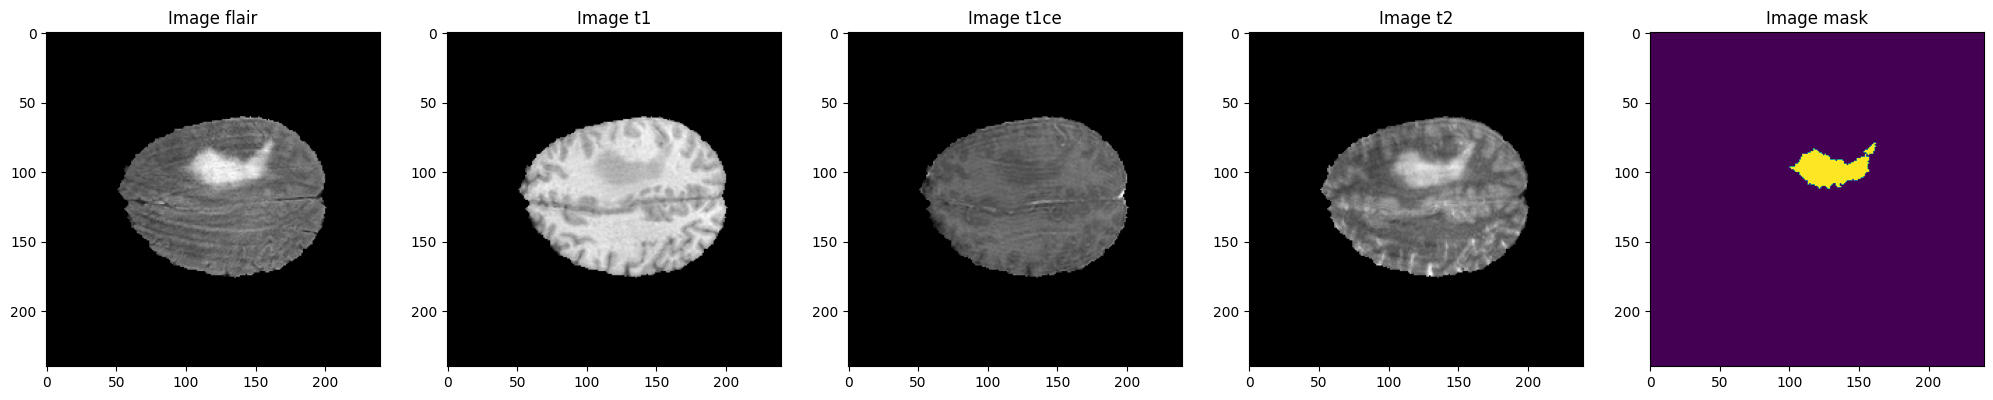

In [3]:
image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
print(image_flair.shape)

image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
image_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata().astype(np.uint8)

image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)
image_t1 = scaler.fit_transform(image_t1.reshape(-1, image_t1.shape[-1])).reshape(image_t1.shape)
image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)
image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

import random
n = random.randint(45,image_mask.shape[2]-45)

plt.figure(figsize=(25,18))

plt.subplot(151)
plt.imshow(image_flair[:,:,n], cmap='gray')
plt.title('Image flair')
plt.subplot(152)
plt.imshow(image_t1[:,:,n], cmap='gray')
plt.title('Image t1')
plt.subplot(153)
plt.imshow(image_t1ce[:,:,n], cmap='gray')
plt.title('Image t1ce')
plt.subplot(154)
plt.imshow(image_t2[:,:,n], cmap='gray')
plt.title('Image t2')
plt.subplot(155)
plt.imshow(image_mask[:,:,n])
plt.title('Image mask')




annotated class 4 to 3 due to class imbalance

In [4]:
print(np.unique(image_mask))
image_mask[image_mask==4] = 3
print(np.unique(image_mask))

[0 1 2 4]
[0 1 2 3]


Text(0.5, 1.0, 'Image mask')

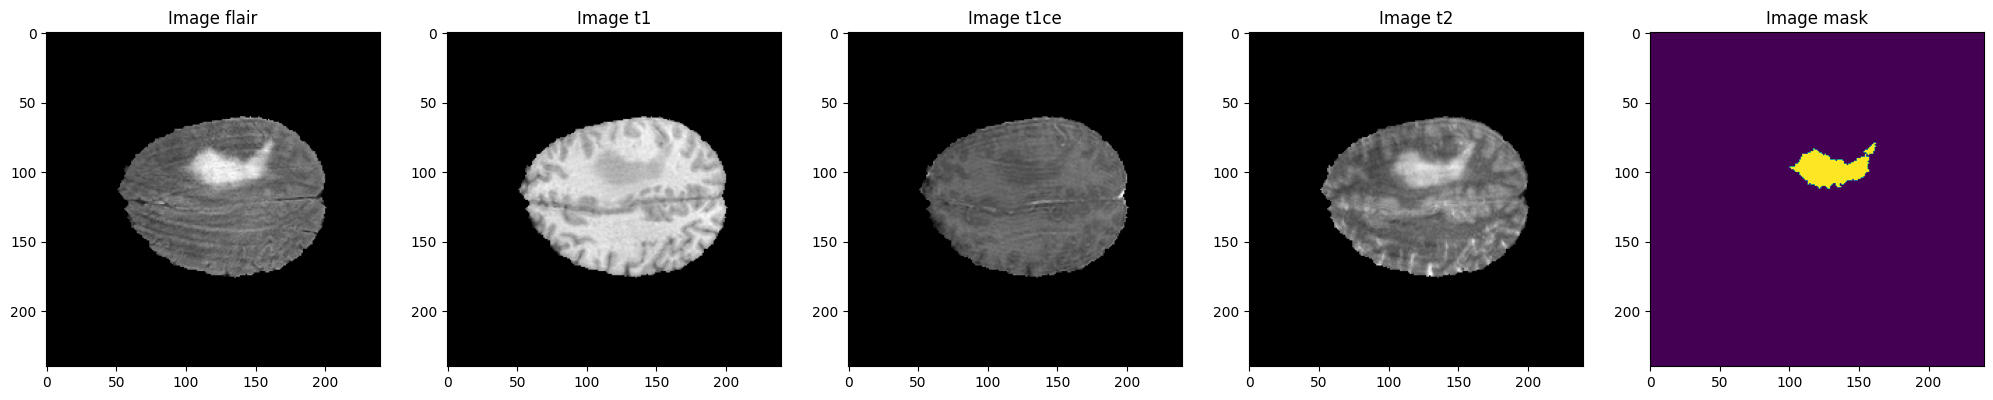

In [5]:
plt.figure(figsize=(25,18))

plt.subplot(151)
plt.imshow(image_flair[:,:,n], cmap='gray')
plt.title('Image flair')
plt.subplot(152)
plt.imshow(image_t1[:,:,n], cmap='gray')
plt.title('Image t1')
plt.subplot(153)
plt.imshow(image_t1ce[:,:,n], cmap='gray')
plt.title('Image t1ce')
plt.subplot(154)
plt.imshow(image_t2[:,:,n], cmap='gray')
plt.title('Image t2')
plt.subplot(155)
plt.imshow(image_mask[:,:,n])
plt.title('Image mask')

reducing the data size to `128 × 128 × 128` by cutting out black area around the brain as its unnecessary for training

In [6]:
combined_image = np.stack([image_flair, image_t1ce, image_t2],axis=3)
combined_image = combined_image[56:184, 56:184, 13:141]
image_mask = image_mask[56:184, 56:184, 13:141]

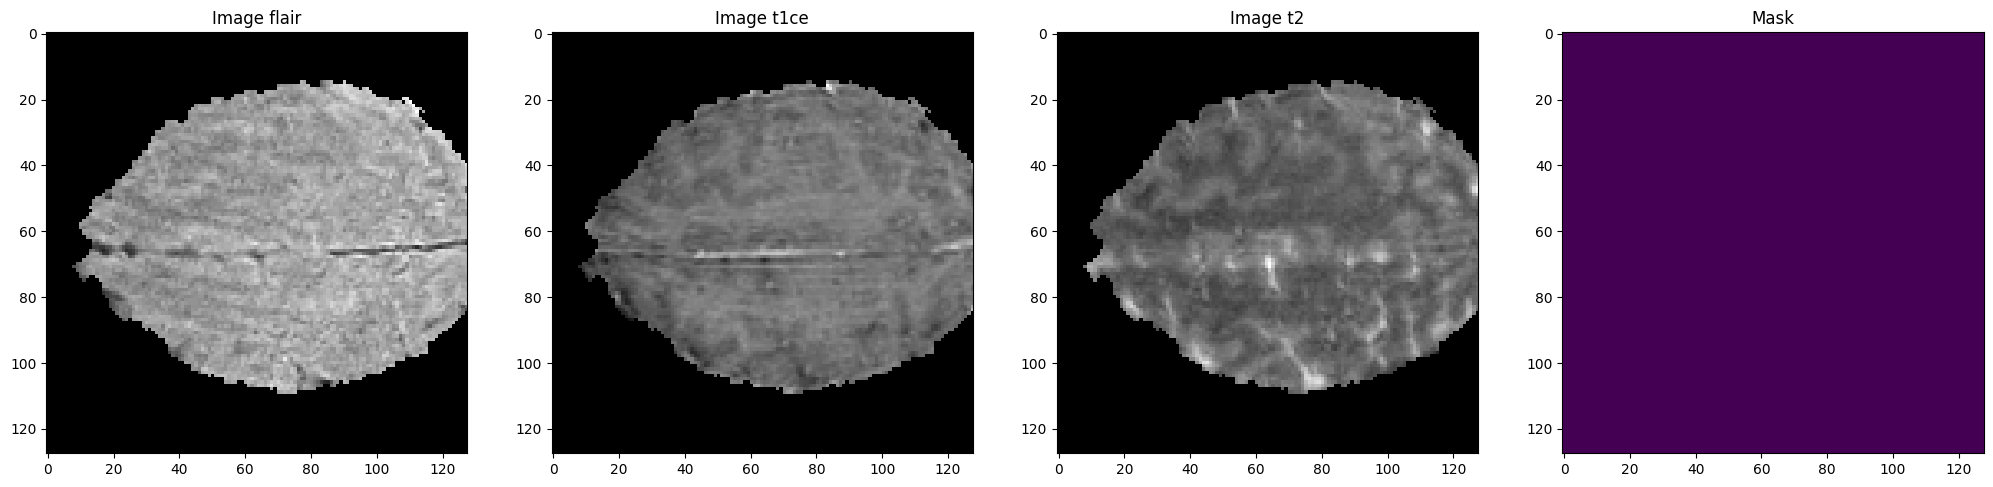

In [7]:
plt.figure(figsize=(25, 8))

plt.subplot(141)
plt.imshow(combined_image[:,:,n, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(combined_image[:,:,n, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(combined_image[:,:,n, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(image_mask[:,:,n])
plt.title('Mask')
plt.show()

In [8]:
np.save('sample_image.npy',combined_image)

## **pre-processing data**
applying all the transformations applied to the example about to all of the training data

In [ ]:
#training data pre-processing
t2_list = sorted(glob.glob(f"{TRAIN_DATASET_PATH}*/*t2.nii"))
t1ce_list = sorted(glob.glob(f"{TRAIN_DATASET_PATH}*/*t1ce.nii"))
flair_list = sorted(glob.glob(f"{TRAIN_DATASET_PATH}*/*flair.nii"))
mask_list = sorted(glob.glob(f"{TRAIN_DATASET_PATH}*/*seg.nii"))

for img in range(len(t2_list)):
    print("preparing image and mask number: ", img)
    
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3 
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(DATASET_PATH+'BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save(DATASET_PATH+'BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")  
    

preparing image and mask number:  0
Save Me
preparing image and mask number:  1
Save Me
preparing image and mask number:  2
Save Me
preparing image and mask number:  3
Save Me
preparing image and mask number:  4
I am useless
preparing image and mask number:  5
Save Me
preparing image and mask number:  6
Save Me
preparing image and mask number:  7


splitting data into training and validation data

In [ ]:
import splitfolders

input_folder = DATASET_PATH+'BraTS2020_TrainingData/input_data_3channels/'
output_folder = DATASET_PATH+'input_data_128/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)


## **Custom Data Generator**

In [8]:
import os

In [9]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return images

In [10]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            # print(f"Loading batch from {batch_start} to {limit}")

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            
            # print(f"Shapes - X: {X.shape}, Y: {Y.shape}")

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [11]:
train_img_dir = DATASET_PATH + "input_data_128/train/images/"
train_mask_dir = DATASET_PATH + "input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

In [12]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [13]:
img, msk = train_img_datagen.__next__()
img.shape

(2, 128, 128, 128, 3)

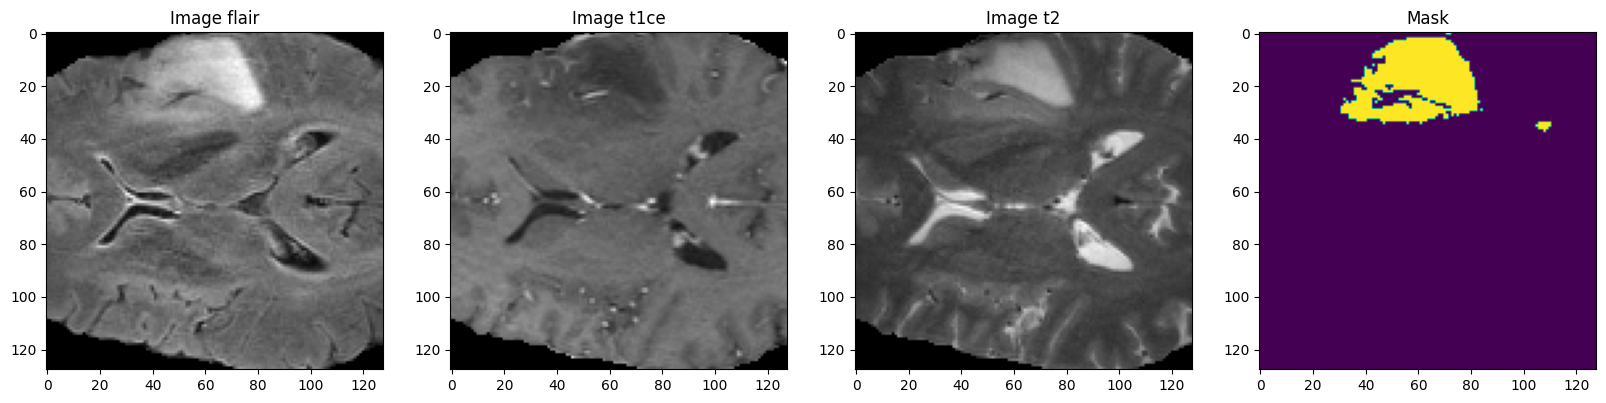

In [14]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
n_slice=60
plt.figure(figsize=(20, 8))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

## **Defining the Model**

The 3D U-Net model is a deep learning architecture designed for volumetric medical image segmentation tasks, enabling precise identification of anatomical structures or abnormalities in 3D medical imaging modalities such as CT, MRI, and PET scans. It extends the original 2D U-Net by incorporating 3D convolutional layers, allowing the model to capture spatial context and features across all three dimensions of input data.

The architecture follows an encoder-decoder framework: the encoder extracts multi-scale features through successive convolutional and max-pooling layers, while the decoder reconstructs the segmentation map using transpose convolutions and skip connections. Skip connections directly transfer spatial features from the encoder to the decoder, preserving fine-grained details and improving segmentation accuracy.

Key features of the 3D U-Net include the ability to handle small datasets efficiently due to data augmentation techniques and the inclusion of dropout layers to mitigate overfitting. Its application is particularly effective for segmenting complex structures in medical images, such as brain tumors, cardiac tissues, and other organs, where 3D spatial information is critical.

The 3D U-Net model has been widely adopted for its high accuracy, robustness, and versatility in medical imaging, making it a benchmark for volumetric image segmentation tasks.

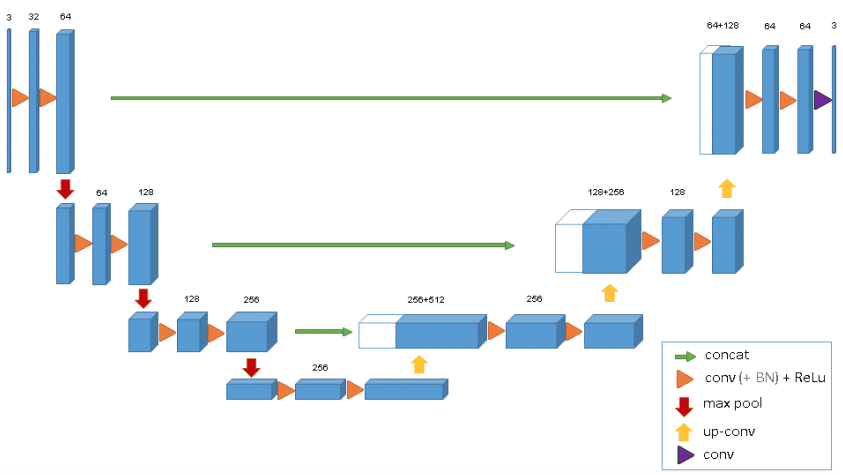

In [15]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [16]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

## **Training the model**

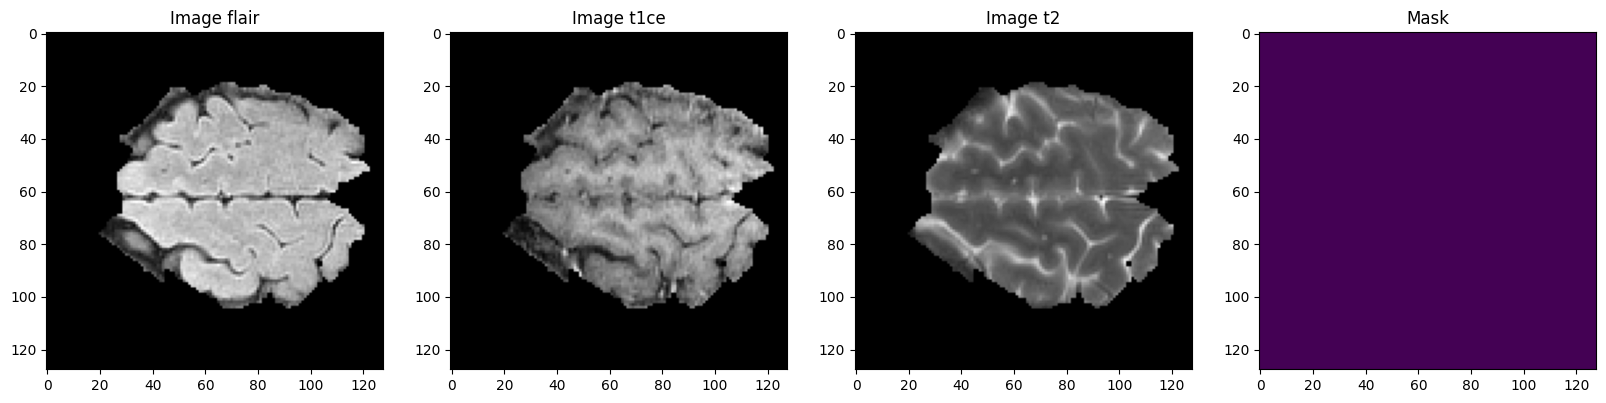

In [17]:
train_img_dir = DATASET_PATH + "input_data_128/train/images/"
train_mask_dir = DATASET_PATH + "input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(20, 8))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [18]:
train_img_dir = DATASET_PATH + "input_data_128/train/images/"
train_mask_dir = DATASET_PATH + "input_data_128/train/masks/"

val_img_dir = DATASET_PATH + "input_data_128/val/images/"
val_mask_dir = DATASET_PATH + "input_data_128/val/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

In [19]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [20]:
img, msk = val_img_datagen.__next__()
print(img.shape)
print(msk.shape)

(2, 128, 128, 128, 3)
(2, 128, 128, 128, 4)


In [21]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy']

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `keras` framework.


In [22]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size
print(steps_per_epoch)
print(val_steps_per_epoch)

129
43


In [23]:
model = simple_unet_model(IMG_HEIGHT=128,IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)

model.compile(optimizer=optim, loss = total_loss, metrics=metrics)

print(model.input_shape)
print(model.output_shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [14]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=80,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    )

model.save('brats_3d.hdf5')

Epoch 1/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1063s 8s/step - accuracy: 0.6444 - loss: 0.8299 - val_accuracy: 0.9521 - val_loss: 0.6886
Epoch 2/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1049s 8s/step - accuracy: 0.9419 - loss: 0.6725 - val_accuracy: 0.9270 - val_loss: 0.6305
Epoch 3/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1050s 8s/step - accuracy: 0.9487 - loss: 0.6118 - val_accuracy: 0.9218 - val_loss: 0.6070
Epoch 4/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1037s 8s/step - accuracy: 0.9517 - loss: 0.5610 - val_accuracy: 0.9460 - val_loss: 0.5096
Epoch 5/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1037s 8s/step - accuracy: 0.9565 - loss: 0.4945 - val_accuracy: 0.9263 - val_loss: 0.5272
Epoch 6/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1026s 8s/step - accuracy: 0.9606 - loss: 0.4603 - val_accuracy: 0.8818 - val_loss: 0.5769
Epoch 7/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1029s 8s/step - accuracy: 0.9643 - loss: 0.4372 - val_accuracy: 0.9402 - val_loss: 0.4860
Epoch 8/80
129/129 ━━━━━━━━━━━━━━━━━━━━ 1021s 8s/step - accuracy: 0.9669 - loss: 0.4063 - 

In [15]:
model.save('BraTS_3d.keras')

In [ ]:
# my_model = load_model('BraTS_3d.keras', compile=False)


my_model = load_model('BraTS_3d.keras', custom_objects=
                       {'DiceLoss': sm.losses.DiceLoss, 
                        'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss,
                        'dice_loss_plus_1focal_loss':total_loss})

my_model.compile(optimizer=optim, 
                 loss=total_loss, 
                 metrics=metrics)

history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

loading already trained model

In [25]:
my_model = load_model('BraTS_3d.hdf5', compile=False)

In [26]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [27]:
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [28]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


making predictions using validation data

In [29]:
img_num = 263

test_img = np.load(DATASET_PATH + 'input_data_128/val/images/image_' + str(img_num) + ".npy")
test_mask = np.load(DATASET_PATH + 'input_data_128/val/masks/mask_' + str(img_num) + ".npy")

test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


plotting the predictions

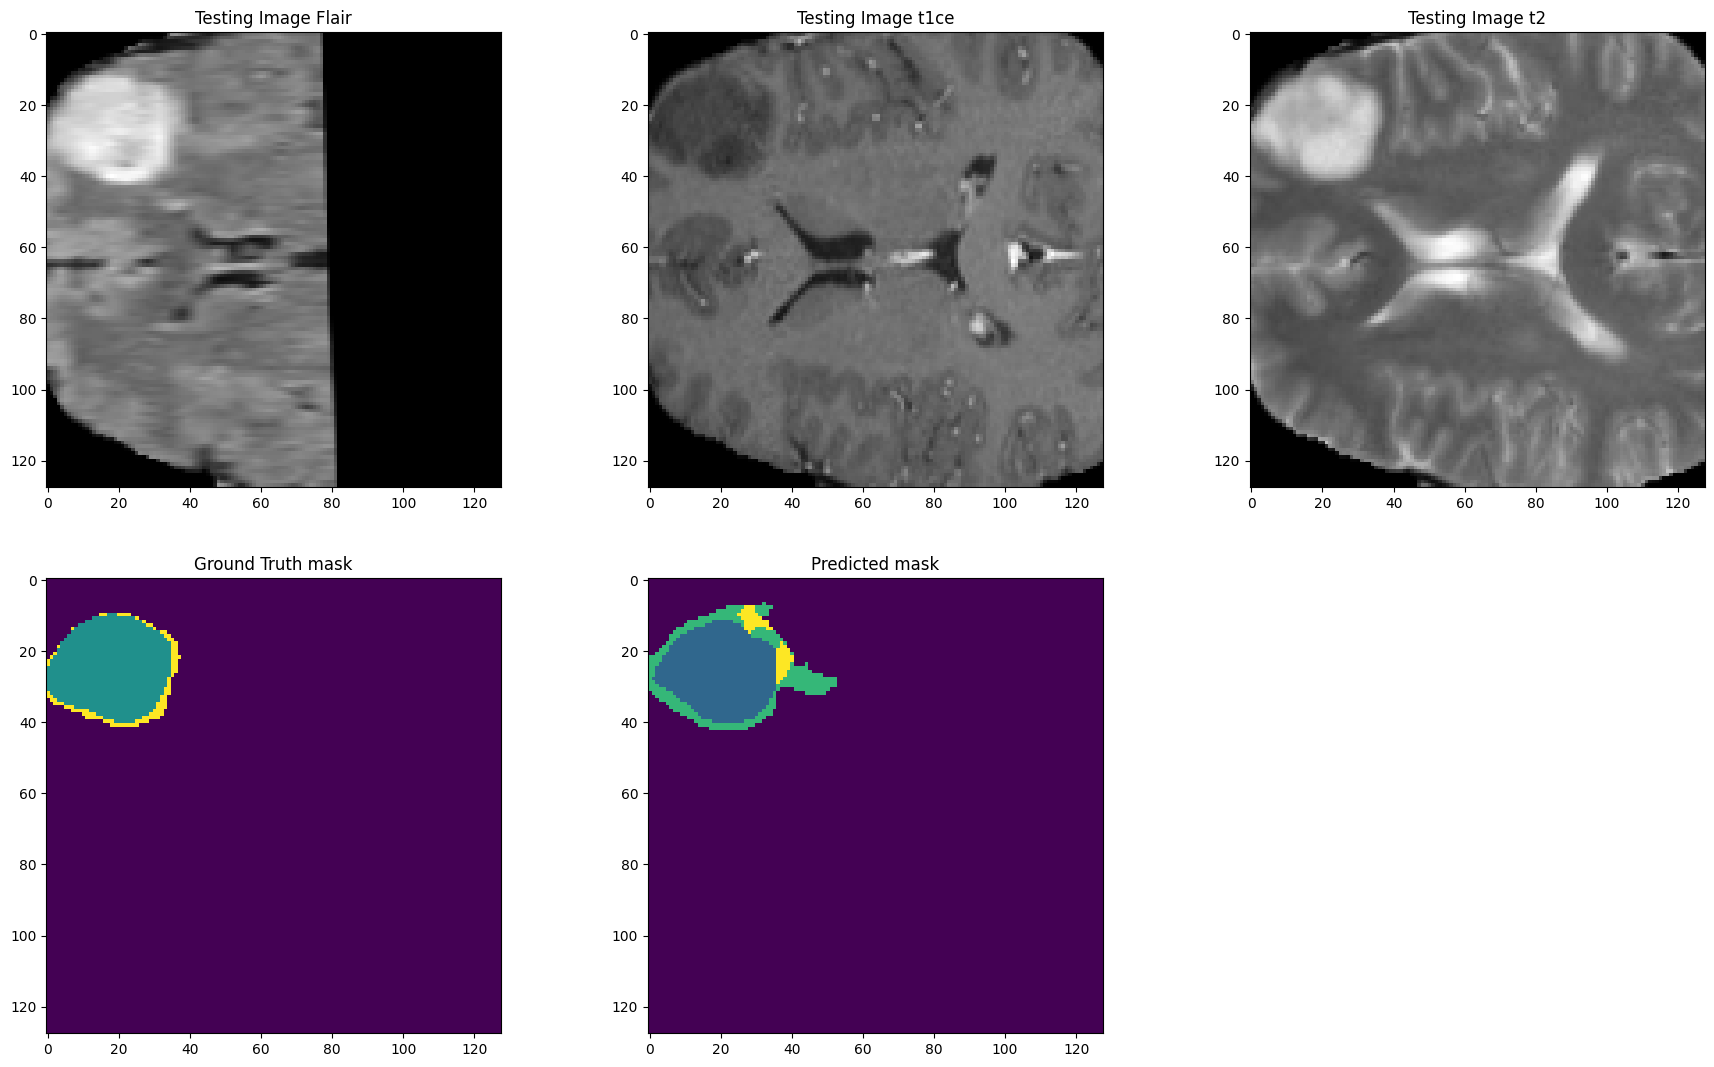

In [32]:
n_slice = 70
plt.figure(figsize=(22, 13))
plt.subplot(231)
plt.title('Testing Image Flair')
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Image t1ce')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(233)
plt.title('Testing Image t2')
plt.imshow(test_img[:,:,n_slice,2], cmap='gray')
plt.subplot(234)
plt.title('Ground Truth mask')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(235)
plt.title('Predicted mask')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

## **Conclusion**  

The **BraTS dataset** provides a robust foundation for developing and evaluating brain tumor segmentation models. Leveraging the multimodal MRI data and expert annotations, our project successfully implemented a 3D U-Net architecture for accurate tumor segmentation. The model achieved an impressive **98% accuracy**, demonstrating its ability to effectively identify and segment complex tumor regions, including enhancing tumor, non-enhancing tumor core, and peritumoral edema.  

This high level of accuracy underscores the model’s potential to support clinicians in diagnosis, treatment planning, and monitoring of brain tumors. The results validate the effectiveness of deep learning techniques, particularly the U-Net architecture, in tackling real-world medical imaging challenges. Future improvements could include incorporating additional data modalities or exploring advanced post-processing techniques to further enhance model performance.  
